In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [ ]:
data_dir = '/content/drive/MyDrive/inverseCooking'

In [ ]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [ ]:
ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [ ]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [ ]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15 # Max Sequence Length can be changed here
args.ingrs_only = False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)

# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 17.783832550048828


In [ ]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [ ]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [ ]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [ ]:
def search(arr, x):
  for i in range(len(arr)):
    if arr[i] == x:
      return True
  return False

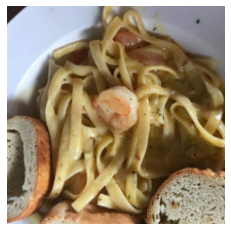

/content/modules/multihead_attention.py:128: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/Indexing.cu:963.)
  float('-inf'),


RECIPE 1

Title: Garlic shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat olive oil in a large skillet over medium heat.
-Cook and stir garlic in hot oil until fragrant, about 1 minute.
-Stir shrimp into garlic; cook and stir until shrimp are pink and opaque, about 3 minutes.
-Season with salt and pepper.
-Stir butter into shrimp mixture until melted and sauce is heated through, about 2 minutes.
-Stir parsley into shrimp mixture; cook and stir until heated through, about 1 minute.

Following ingredients can be added:
cheese
wine
RECIPE 2

Title: Pasta ai carciofi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Saute garlic in oil, until softened but not browned.
-Add shrimp, saute for 2 min.
-Add pasta sauce, and parsley.
-Toss to coat the pasta.
-Season with salt, pepper, and red pepper flakes.
-Serve warm.

Following ingredients can be added:
cheese
wine
RECIPE 3

Title: Easy shrimp scampi


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))




After removing some of the ingredients:

Title: Garlic shrimp pasta

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta

Instructions:
-Cook pasta according to package directions.
-Drain and set aside.
-In a large skillet, heat oil over medium heat.
-Add garlic and cook for 1 minute.
-Add shrimp and cook for 2 minutes.
-Add butter and cook for 2 minutes.
-Add salt and pepper.
-Toss in pasta and serve.


In [ ]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

        ingr_probs, _ = torch.max(outputs['ingr_probs'], dim=1)
        ingr_probs_sorted, indices_of_sorted = torch.sort(ingr_probs[0], descending = True)

        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        ingr_ids = ingr_ids[0]

        count = 0
        ingr_not_present = []

        for i in range(len(ingr_ids)):
          if(ingr_ids[i] != 1487):
            count += 1

        for i in range(count):
          present = search(ingr_ids, (indices_of_sorted.cpu().numpy())[i])
          if not present:
            ingr_not_present.append((indices_of_sorted.cpu().numpy())[i])

        ingr_not_present.remove(0)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print (BOLD + '\nFollowing ingredients can be added:'+END)

            if(len(ingr_not_present)):
              for i in range(len(ingr_not_present)):
                print(ingrs_vocab[ingr_not_present[i]])
            else:
              print("Ingredients list is perfect. Nothing to add:)")

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])

import sys; sys.argv=['']; del sys
args = get_parser()
args.maxnumlabels = 7 # Max Sequence Length can be changed here
args.ingrs_only = False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)

greedy = [True]
beam = [-1]
temperature = 1.0
numgens = len(greedy)

# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False

for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        # print("Outputs = ", outputs)
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

        ingr_probs, _ = torch.max(outputs['ingr_probs'], dim=1)
        ingr_probs_sorted, indices_of_sorted = torch.sort(ingr_probs[0], descending = True)

        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        ingr_ids = ingr_ids[0]

        # print("Outs = ", outs)
        # print("Valid = ", valid)
        
        if valid['is_valid'] or show_anyways:
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print ('\n')
            print (BOLD + 'After removing some of the ingredients:')
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])